# set up

In [1]:
!pip install tensorflow_datasets


In [2]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Getting the data

First, let's fetch the cats vs. dogs dataset using TFDS. If you have your own dataset, you'll probably want to use the utility keras.utils.image_dataset_from_directory to generate similar labeled dataset objects from a set of images on disk filed into class-specific folders.

Transfer learning is most useful when working with very small datasets. To keep our dataset small, we will use 40% of the original training data (25,000 images) for training, 10% for validation, and 10% for testing.

In [15]:
import tensorflow_datasets as tfds

# Load the 'cats_vs_dogs' dataset from TFDS, and split into train, validation, and test sets
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels (images will be paired with labels)
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.ZSY48U_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


These are the first 9 images in the training dataset – as you can see, they're all different sizes.

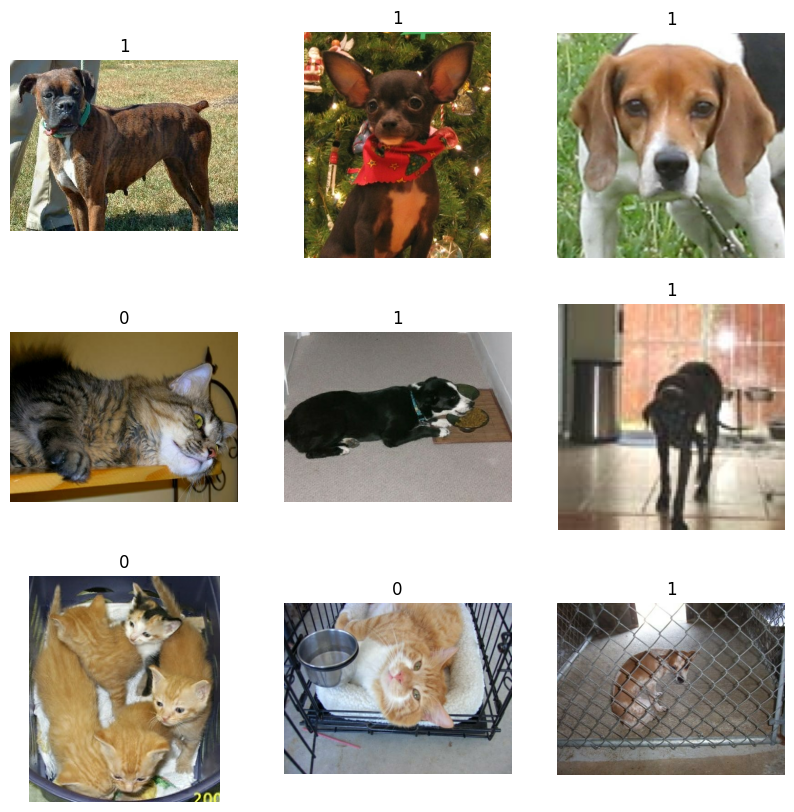

In [16]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

**We can also see that label 1 is "dog" and label 0 is "cat".**

Standardizing the data
Our raw images have a variety of sizes. In addition, each pixel consists of 3 integer values between 0 and 255 (RGB level values). This isn't a great fit for feeding a neural network. We need to do 2 things:

Standardize to a fixed image size. We pick 150x150.
Normalize pixel values between -1 and 1. We'll do this using a Normalization layer as part of the model itself.
In general, it's a good practice to develop models that take raw data as input, as opposed to models that take already-preprocessed data. The reason being that, if your model expects preprocessed data, any time you export your model to use it elsewhere (in a web browser, in a mobile app), you'll need to reimplement the exact same preprocessing pipeline. This gets very tricky very quickly. So we should do the least possible amount of preprocessing before hitting the model.

Here, we'll do image resizing in the data pipeline (because a deep neural network can only process contiguous batches of data), and we'll do the input value scaling as part of the model, when we create it.

Let's resize images to 150x150

In [17]:
# Define a resizing function to resize images to 150x150 pixels.
resize_fn = keras.layers.Resizing(150, 150)

# Apply the resizing function to each image in the training dataset.
# This uses the map function to transform each (image, label) pair by resizing the image.
train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))

# Apply the resizing function to each image in the validation dataset.
# This step ensures that validation images match the expected input shape.
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))

# Apply the resizing function to each image in the test dataset.
# Resizing test images keeps all data consistent in shape for evaluation.
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))


Using random data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [18]:
# Define a list of data augmentation layers to apply random transformations to images.
augmentation_layers = [
    layers.RandomFlip("horizontal"),   # Randomly flip images horizontally (e.g., mirroring left to right).
    layers.RandomRotation(0.1),        # Randomly rotate images up to 10% of a full rotation (0.1 radians).
]

# Define a function that applies the augmentation layers to an input image `x`.
def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)  # Apply each augmentation layer in sequence to the input image.
    return x  # Return the augmented image.

# Map the data_augmentation function to each image in the training dataset.
# This applies the augmentation to each training image, but leaves the label `y` unchanged.
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))


Let's batch the data and use prefetching to optimize loading speed.

In [19]:
from tensorflow import data as tf_data

# Set the batch size for the dataset.
batch_size = 64

# Batch the training dataset, cache it in memory, and prefetch batches for optimized loading.
train_ds = (
    train_ds
    .batch(batch_size)              # Group images and labels into batches of 64.
    .cache()                        # Cache the dataset in memory to speed up access during training.
    .prefetch(tf_data.AUTOTUNE)     # Prefetch batches in the background while the model trains, improving performance.
)

# Batch, cache, and prefetch the validation dataset in the same way as the training set.
validation_ds = (
    validation_ds
    .batch(batch_size)              # Group validation samples into batches of 64.
    .cache()                        # Cache the dataset to reduce I/O during evaluation.
    .prefetch(tf_data.AUTOTUNE)     # Prefetch for optimized loading, allowing the model to evaluate smoothly.
)

# Batch, cache, and prefetch the test dataset in the same way as the training set.
test_ds = (
    test_ds
    .batch(batch_size)              # Group test samples into batches of 64.
    .cache()                        # Cache in memory to speed up test evaluations.
    .prefetch(tf_data.AUTOTUNE)     # Prefetch for smoother evaluation performance.
)


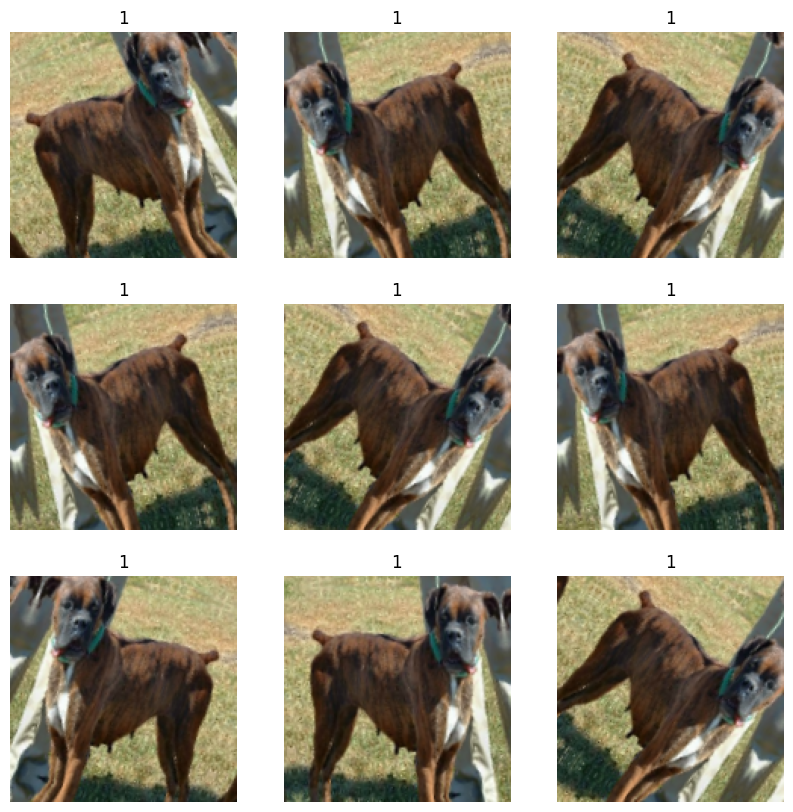

In [20]:
#Let's visualize what the first image of the first batch looks like after various random transformations:

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

# **Build a model**
Now let's built a model that follows the blueprint we've explained earlier.

Note that:

We add a Rescaling layer to scale input values (initially in the [0, 255] range) to the [-1, 1] range.
We add a Dropout layer before the classification layer, for regularization.
We make sure to pass training=False when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.

In [21]:
# Load the base model Xception with pre-trained ImageNet weights, excluding the top (fully connected) layer.
base_model = keras.applications.Xception(
    weights="imagenet",       # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3), # Set input shape; images are 150x150 pixels with 3 color channels (RGB).
    include_top=False          # Exclude the final classification layer to allow adding custom layers.
)  # Do not include the ImageNet classifier at the top.

# Freeze the base model layers so they will not be updated during training.
base_model.trainable = False

# Create a new model with a custom input layer.
inputs = keras.Input(shape=(150, 150, 3))

# Add a rescaling layer to preprocess the input for Xception. Xception expects input values between -1 and +1.
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# Pass the scaled inputs to the base model.
# Set training=False to ensure batch normalization layers remain in inference mode,
# even if the base model is unfrozen later for fine-tuning.
x = base_model(x, training=False)

# Apply global average pooling to reduce the spatial dimensions, creating a 1D tensor per image.
x = keras.layers.GlobalAveragePooling2D()(x)

# Add dropout for regularization to prevent overfitting.
x = keras.layers.Dropout(0.2)(x)  # Dropout rate of 0.2 (20%).

# Add the final output layer with 1 neuron (for binary classification, e.g., cat vs dog).
outputs = keras.layers.Dense(1)(x)

# Define the final model by specifying inputs and outputs.
model = keras.Model(inputs, outputs)

# Print a summary of the model, showing which layers are trainable.
model.summary(show_trainable=True)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_6 (InputLayer)          │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling (Rescaling)               │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 5, 5, 2048)           │    20,861,480 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_1          │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_8 (Dense)                     │ (None, 1)                    │         2,049 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

# Train the top layer

In [22]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 1178s 8s/step - binary_accuracy: 0.8832 - loss: 0.2507 - val_binary_accuracy: 0.9682 - val_loss: 0.0860
Epoch 2/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 1037s 7s/step - binary_accuracy: 0.9461 - loss: 0.1245 - val_binary_accuracy: 0.9725 - val_loss: 0.0786


# **Do a round of fine-tuning of the entire model**
Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.

Importantly, although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [23]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_6 (InputLayer)          │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling (Rescaling)               │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 5, 5, 2048)           │    20,861,480 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_1          │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_8 (Dense)                     │ (None, 1)                    │         2,049 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 4,100 (16.02 KB)

Fitting the end-to-end model
146/146 ━━━━━━━━━━━━━━━━━━━━ 3851s 26s/step - binary_accuracy: 0.8583 - loss: 0.3596 - val_binary_accuracy: 0.9630 - val_loss: 0.1049


In [24]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
37/37 ━━━━━━━━━━━━━━━━━━━━ 205s 5s/step - binary_accuracy: 0.9607 - loss: 0.0961


[0.10820912569761276, 0.9578675627708435]

Path of the image to be predicted: /content/download (1).jpeg


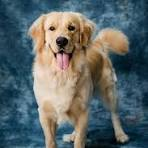

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
[[0.11024223]]
0
The image represents a Dog


In [35]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)

cv2_imshow(input_image)

# Resize to the expected input shape of the model
input_image_resize = cv2.resize(input_image, (150, 150))

input_image_scaled = input_image_resize / 255.0  # Normalize the image

image_reshaped = np.reshape(input_image_scaled, [1, 150, 150, 3])  # Reshape for the model

input_prediction = model.predict(image_reshaped)

print(input_prediction)

input_pred_label = np.argmax(input_prediction)

print(input_pred_label)

if input_pred_label == 0:
    print('The image represents a Cat')
else:
    print('The image represents a Dog')


Path of the image to be predicted: /content/download (3).jpeg


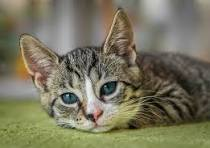

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
[[0.11471539]]
0
The image represents a cat


In [34]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)

cv2_imshow(input_image)

# Resize to the expected input shape of the model
input_image_resize = cv2.resize(input_image, (150, 150))

input_image_scaled = input_image_resize / 255.0  # Normalize the image

image_reshaped = np.reshape(input_image_scaled, [1, 150, 150, 3])  # Reshape for the model

input_prediction = model.predict(image_reshaped)

print(input_prediction)

input_pred_label = np.argmax(input_prediction)

print(input_pred_label)

if input_pred_label == 1:
    print('The image represents a dog')
else:
    print('The image represents a cat')
